In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [26]:
user_ids = df['userId'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [27]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [28]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
print("number of users: ", num_users)
print("number of movies: ", num_movies)

number of users:  610
number of movies:  9724


In [29]:
min_rating = min(df['rating'])
max_rating = max(df['rating'])
print("min : ", min_rating)
print("max : ", max_rating)

min :  0.5
max :  5.0


In [30]:
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


### Preprocess the data:

In [31]:
# random shuffle
df = df.sample(frac=1, random_state=123)
#df.head()
# extract user and movie as a numpy array
X = df[['user', 'movie']].values
# extract and normalize ratings
Y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [54]:
print(X[:10])

[[ 104  243]
 [  21  439]
 [ 473 4231]
 [ 318 2542]
 [ 549  256]
 [ 540  588]
 [ 176 5234]
 [ 104 2234]
 [ 358   34]
 [  83  687]]


In [32]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.1)

print("train_X : {}, train_Y : {}, test_X : {}, test_Y : {}".format(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape))

train_X : (90752, 2), train_Y : (90752,), test_X : (10084, 2), test_Y : (10084,)


In [50]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [51]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [52]:
history = model.fit(train_X, train_Y, batch_size=64, epochs=5, validation_data=(test_X, test_Y))

Epoch 1/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6373 - val_loss: 0.6177
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6138 - val_loss: 0.6154
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6090 - val_loss: 0.6119
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6083 - val_loss: 0.6093
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6075 - val_loss: 0.6086


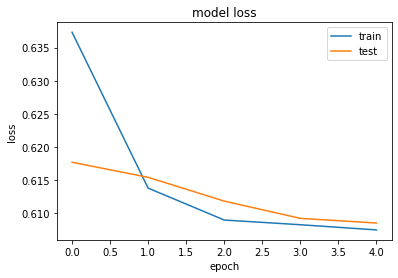

In [53]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

### predict top 10 movie recommendations

In [109]:
movie_df = pd.read_csv('movies.csv')
#movie_df.head()
user_id = df.userId.sample(1).iloc[0]
print("user_id :", user_id)
movies_watched_by_user = df[df.userId == user_id]
#movies_watched_by_user.head()
list_watched_movies = movies_watched_by_user.movieId.values.tolist()
print("number of watched movies by the selected user : ", len(list_watched_movies))
movies_not_watched_by_user = movie_df[~movie_df.movieId.isin(list_watched_movies)].movieId
#movies_not_watched_by_user.head()
print("number of all movies :", len(movie_df.index))
print("number of unwatched movies by user :", len(movies_not_watched_by_user.index))
# pick only available movies from movies.csv
movies_not_watched = list(
    set(movies_not_watched_by_user).intersection(set(movie2movie_encoded.keys()))
)

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
print(len(movies_not_watched))

user_enc = user2user_encoded.get(user_id)
print("encoded user_id : ", user_enc)

user_movie_array = np.hstack(
    ([[user_enc]] * len(movies_not_watched), movies_not_watched)
)
print(user_movie_array.shape)
print(user_movie_array[:5])

ratings_pred = model.predict(user_movie_array).reshape(-1)
print(ratings_pred.shape)

user_id : 610
number of watched movies by the selected user :  1302
number of all movies : 9742
number of unwatched movies by user : 8440
8422
encoded user_id :  609
(8422, 2)
[[ 609 5804]
 [ 609  481]
 [ 609    1]
 [ 609  482]
 [ 609  483]]
(8422,)


In [117]:
# pick top 10 ratings indices
top_ratings_indices = ratings_pred.argsort()[-10:][::-1]
recommended_movie_id = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]
print(recommended_movie_id)

[1288, 2329, 1193, 1278, 1272, 1266, 3275, 1267, 475, 1299]


In [121]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (movies_watched_by_user.sort_values(by='rating', ascending=False).head(5).movieId.values)
movie_df_rows = movie_df[movie_df.movieId.isin(top_movies_user)]

for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
top_recommendation_user = movie_df[movie_df.movieId.isin(recommended_movie_id)]
for row in top_recommendation_user.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 610
Movies with high ratings from user
--------------------------------
Godfather: Part II, The (1974) : Crime|Drama
Legend of Drunken Master, The (Jui kuen II) (1994) : Action|Comedy
City of God (Cidade de Deus) (2002) : Action|Adventure|Crime|Drama|Thriller
Battle Royale (Batoru rowaiaru) (2000) : Action|Drama|Horror|Thriller
Mad Max: Fury Road (2015) : Action|Adventure|Sci-Fi|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
In the Name of the Father (1993) : Drama
One Flew Over the Cuckoo's Nest (1975) : Drama
Unforgiven (1992) : Drama|Western
Manchurian Candidate, The (1962) : Crime|Thriller|War
Patton (1970) : Drama|War
Young Frankenstein (1974) : Comedy|Fantasy
This Is Spinal Tap (1984) : Comedy
Killing Fields, The (1984) : Drama|War
American History X (1998) : Crime|Drama
Boondock Saints, The (2000) : Action|Crime|Drama|Thriller


In [ ]:

user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)